## Lesson 6 - Random Forest


### Reload the data



In [24]:
import os
from pathlib import Path
from fastai.imports import *  # imports the usual suspects
path = Path('data/titanic')
df = pd.read_csv(path/'train.csv')

In [25]:
modes = df.mode().iloc[0]

def proc_data(df):
    df['Fare'] = df.Fare.fillna(0)
    df.fillna(modes, inplace=True)  # fill missing values with mode
    df['LogFare'] = np.log1p(df['Fare'])
    df['Embarked'] = pd.Categorical(df.Embarked)
    df['Sex'] = pd.Categorical(df.Sex)

proc_data(df)

# I am not bothering with the test data for now, i dont plan to submit this.

In [26]:
cats=["Sex","Embarked"]
conts=['Age', 'SibSp', 'Parch', 'LogFare',"Pclass"]
dep="Survived"

In [27]:
from sklearn.model_selection import train_test_split
from numpy import random

random.seed(42)
trn_df,val_df = train_test_split(df, test_size=0.25)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes) # convert to codes 
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes) # convert to codes

# Create x's and y's 
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

### Video lesson 

* First he goes through the 'manual' [OneR](https://link.springer.com/article/10.1023/A:1022631118932) again from last week to catch us up. 

* Then continues to work through [How random forests work](https://www.kaggle.com/code/jhoward/how-random-forests-really-work/)  

    * Builds a decision tree one level deeper then 1 R, looking for the next split.

    * Note that he is sitll  using the standard deviation * number of points in a leaf as a score (see notebook)

    * Then on to using sklearn's decision tree


In [28]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y);

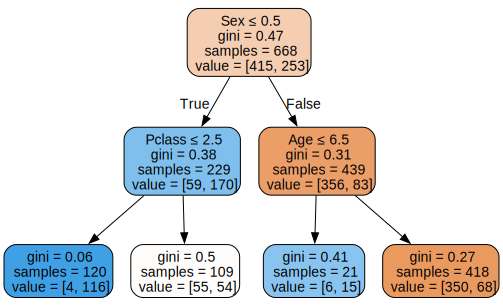

In [29]:

import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))


draw_tree(m, trn_xs, size=10)

* Decision trees like this are very useful for understanding the data -- quick picture of key variables

* gini is another impurity measure, and the one used by default in sklearn. It is a measure of statistical dispersion, intended to represent the probability that two elements chosen randomly from the dataset would be incorrectly labeled if they were randomly labeled according to the distribution of labels in the dataset. 

$$
G = 1 - \sum_i p_i^2
$$
This score is cacluated for each leaf node, summing over the number of classes. $p_i$ is the fraction in that node of class i.






Ok how does this do on validation set?  Jeremy uses mean absolute error, which is the same as one miuse the accuracy here since the tree only predicts 0 or 1.

In [30]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, m.predict(val_xs))

0.2242152466367713

Its wrong 22% of the time.  Lets try a deeper tree

In [31]:
m = DecisionTreeClassifier(min_samples_leaf=50)
m.fit(trn_xs, trn_y)
mean_absolute_error(val_y, m.predict(val_xs))


0.18385650224215247

#### Remarks on categorical variables

* You don't need to create dummies for trees, since they can split on the categories directly.

* For small number of categories, it can be more efficient to use one-hot encoding to avoid having to split multiple times on the same variable to get out an important category that is in the middle. 

#### Random Forests

* We can't keep making the tree deeper, eventually it will over fit (memorize the data) with only 1 data point in each terminal node! 

* AN alternative is to use bagging, which is to train multiple trees on different subsets of the data and average the results.  Random forests also use random subset of features for each split. 

In [32]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=10)
rf.fit(trn_xs, trn_y);
mean_absolute_error(val_y, rf.predict(val_xs))

0.19282511210762332

Random forests also have a feature to help find which features are important.  It is the average of the decrease in impurity for each feature.

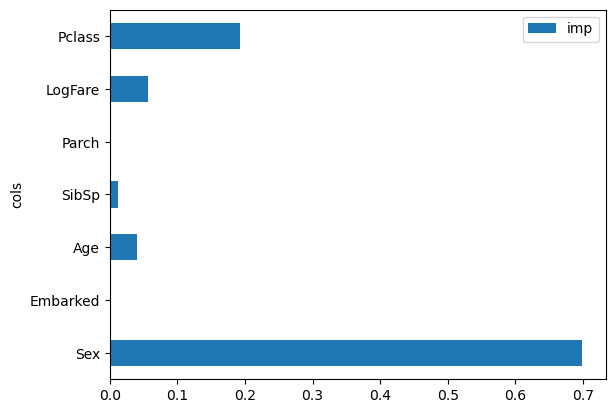

In [33]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh');

### Video now goes into the chapter notebook  

See below for my highlights of chapter 9.  

####  out-of-bag error

* The out-of-bag error is the error on the data that was not used to train the tree.  This is a good estimate of the error on new data.  It is the average of the error on each tree for the data that was not used to train that tree.

* Built in to sklearn as well. But you have to specify oob_score=True when you create the RandomForestClassifier.

In [34]:
rf = RandomForestClassifier(100, min_samples_leaf=10, oob_score=True)
rf.fit(trn_xs, trn_y);
rf.oob_score_

0.811377245508982

Note that oob_prediction_ is no longer available for RandomForestClassifier. However it is still available for RandomForestRegressor.  

* ALLWAYS start a tabular data project with a random forest to get a sense of the data.  It is a good way to get a sense of the data and what is important!

#### Partial Dependence 

* What is the relationship between features and dependant variables.  This is usually computed for a small set of features (one or two), marginalizing over the other features .  In practice this means, for each value of the selected variable, predicting with the model for each row using the  existing values for the other variables (those being marginalized over.) Average over the other.

* Can be done with any machine learning model. 

* `sklearn.inspection` has `partial_dependence` (no longer has `plot_partial_dependence`, but there is `PartialDependenceDisplay` class.)

#### Gradient boosting

* Generally fits better, but is a bit more finicky (you can overfit)

* See [How to explain gradient boosting](https://explained.ai/gradient-boosting/index.html)

### More highlights Chapter 9

*  If OOB significantly better then validation error, consider that something beyond generalization error is causing underfitting.

* Interpretation
    * Standard deviation of the (random) tree results give a measure of confidence on the trees prediction
    * SKlearn can provide feature importance (computed by looking at how much the model improved when splitting on those features).
    * Feature importance can be used to select unimportant features to remove and simplify the model.
    * `cluster_columns`  can be used to identify redundant columns to try and remove (checking `oob` score to see if it is effected ).  `cluster_columns` is defined in the books `utils.py`  as:

        ```
        from scipy.cluster import hierarchy as hc

        def cluster_columns(df, figsize=(10,6), font_size=12):
            corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
            corr_condensed = hc.distance.squareform(1-corr)
            z = hc.linkage(corr_condensed, method='average')
            fig = plt.figure(figsize=figsize)
            hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
            plt.show()
        ```
    * Partial dependance plots help understand how the results depend on each variable, all other variables held constant. (Counterfactual!)
    * Library `treeinterpreter` can be used to show for predicting a particular row of data, what were the most important factors, and how did they influence the prediction.  Basically feature importance but for a particular prediction.  `treeintepreter` library can do this automatically.


* Data Leakage: Be careful, sometime data is missing for a reason, and that reason might be related to the value you are trying to predict!!  Models can help... are some variables more predictive the you expect? Do some variables partial dependance not make sense?


* Random forests and related methods are bad at extrapolation (just predict constant values outside the domain fo the data)
   * Book chapter shows a cool trick to detect issues like this: Train a random forest to predict if a data point is in the test set or validation set.  
   * This can uncover "domain_shift" issues, for example in the chapter, machine_id and sales_id both encode the date of sale (albeit imperfectly) and so predict well (for this case) train vs validation.

* Fast.ai's `TabularLearner` was demonstrated next. This is by default a two hidden layer neural network that uses embedding for the categorical variables. It does slightly better.  Even better is ensembling this with the forest results! Note: Default is hidden layers are 100,200 and default embedding is `min(600, 1.6*n_cat**0.56)`

* Boosting is mentioned breifly, and that XGBoost is the state of the art at the time of writing. ALso that boosting tends to be more susceptable to overfitting and can be more sensitive to hyperparameters.

* Embeddings obtained by training a neural net (perhaps on another task!) can be used as input features for your Random forest or other machine learning methods. (Guo and Berkhahn 2016, Entity Embeddings of Categorical Variables)

## Road to the top

Jeremy walked through his [Road to the top part 1](https://www.kaggle.com/code/jhoward/first-steps-road-to-the-top-part-1) and [part 2](https://www.kaggle.com/code/jhoward/small-models-road-to-the-top-part-2/) notebooks where he hit the top of the leaderboard on rice paddy disease recognition.

Highlights:

* fastkaggle - automates some aspects of setting up a kaggle notebook. 

* Focus on creating an effective validation data set and *iterate* to find solutions that improve results on the validation set   (i worry here about overfitting the validation data though!)

* Build a model as soon as you can, to help you understand the data! 

* Test time augmentation can help predictions in vision models. (ensembling!)